In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
# from tools.GRU_SingleStep_v10 import RNN_GRU
from tools.CrossAttentionRNN_SingleStep_v3 import RNN_CrossAttention as RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-08 20:56:55.807447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 20:56:55.808067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 20:56:55.891479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 20:56:55.891786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 20:56:55.892030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

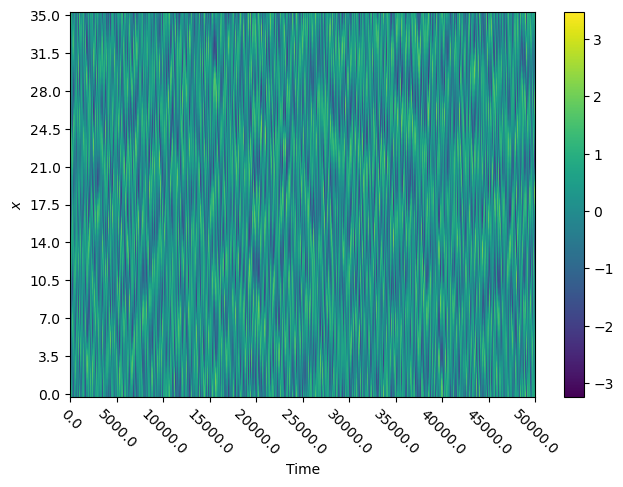

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

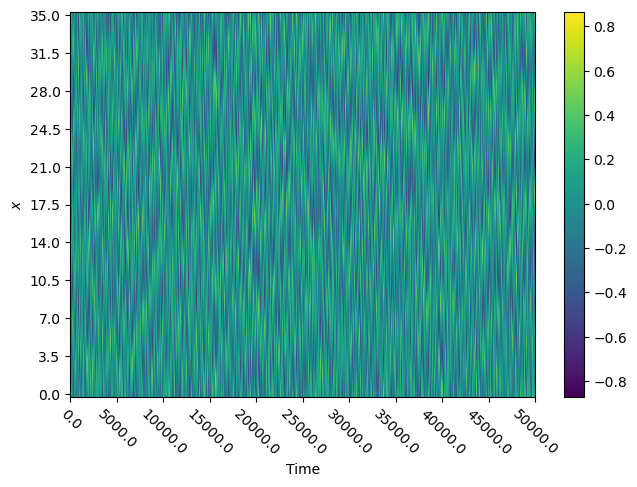

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

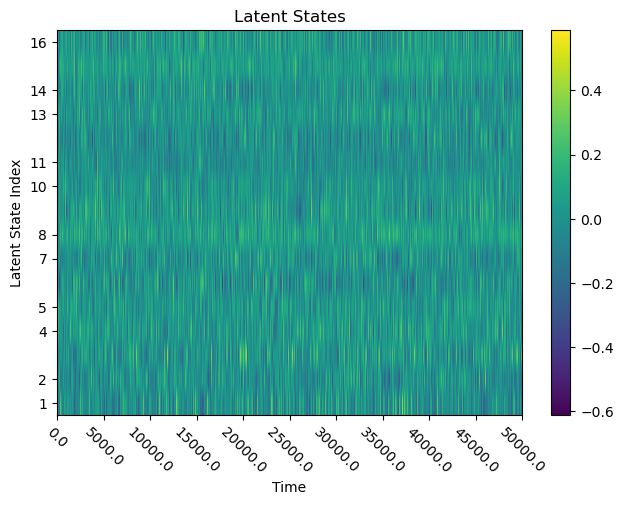

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 2.5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 2/100
    zoneout_rate = 0.1
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]

    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (1024, 193, 16)
 testing_data_rnn_input.shape :  (128, 193, 16)
     val_data_rnn_input.shape :  (128, 193, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [250]
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=None, # corresponding to RK4
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=None, # corresponding to RK4
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.006613247394561768


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

train_gpa_hist = []
train_gpra_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        train_gpa_hist.extend(history.history['gamma_prime_attention'])
        train_gpra_hist.extend(history.history['gamma_prime_recurrent_attention'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 0.0933 - mse: 0.0928 - NMSE: 0.8350 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 0h 1m 9.9s

Epoch 1: val_NMSE improved from inf to 0.65781, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 70s 1s/step - loss: 0.0933 - mse: 0.0928 - NMSE: 0.8350 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 0.0736 - val_mse: 0.0731 - val_NMSE: 0.6578 - val_gamma_prime_attention: 0.0000e

Epoch 11/200
64/64 [==============================] - ETA: 0s - loss: 9.5806e-04 - mse: 5.0759e-04 - NMSE: 0.0046 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 0h 12m 31.0s

Epoch 11: val_NMSE improved from 0.00417 to 0.00415, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 9.5806e-04 - mse: 5.0759e-04 - NMSE: 0.0046 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 9.1000e-04 - val_mse: 4.6052e-04 - val_NMSE: 0.0041 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 12/200
64/64 [==============================] - ETA: 0s - loss: 9.5389e-04 - mse: 5.0513e-04 - NMSE: 0.0045 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 21/200
64/64 [==============================] - ETA: 0s - loss: 9.1992e-04 - mse: 4.8417e-04 - NMSE: 0.0044 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 0h 23m 51.7s

Epoch 21: val_NMSE improved from 0.00396 to 0.00393, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 9.1992e-04 - mse: 4.8417e-04 - NMSE: 0.0044 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 8.7182e-04 - val_mse: 4.3692e-04 - val_NMSE: 0.0039 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 22/200
64/64 [==============================] - ETA: 0s - loss: 9.1620e-04 - mse: 4.8204e-04 - NMSE: 0.0043 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 31/200
64/64 [==============================] - ETA: 0s - loss: 8.8093e-04 - mse: 4.6174e-04 - NMSE: 0.0042 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 0h 35m 11.2s

Epoch 31: val_NMSE improved from 0.00374 to 0.00372, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 8.8093e-04 - mse: 4.6174e-04 - NMSE: 0.0042 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 8.3185e-04 - val_mse: 4.1351e-04 - val_NMSE: 0.0037 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 32/200
64/64 [==============================] - ETA: 0s - loss: 8.7723e-04 - mse: 4.5975e-04 - NMSE: 0.0041 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 41/200
64/64 [==============================] - ETA: 0s - loss: 8.4350e-04 - mse: 4.4151e-04 - NMSE: 0.0040 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 0h 46m 31.6s

Epoch 41: val_NMSE improved from 0.00355 to 0.00354, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 8.4350e-04 - mse: 4.4151e-04 - NMSE: 0.0040 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 7.9394e-04 - val_mse: 3.9277e-04 - val_NMSE: 0.0035 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 42/200
64/64 [==============================] - ETA: 0s - loss: 8.3993e-04 - mse: 4.3964e-04 - NMSE: 0.0040 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 51/200
64/64 [==============================] - ETA: 0s - loss: 8.0932e-04 - mse: 4.2392e-04 - NMSE: 0.0038 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 0h 57m 50.5s

Epoch 51: val_NMSE improved from 0.00338 to 0.00336, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 8.0932e-04 - mse: 4.2392e-04 - NMSE: 0.0038 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 7.5790e-04 - val_mse: 3.7325e-04 - val_NMSE: 0.0034 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 52/200
64/64 [==============================] - ETA: 0s - loss: 8.0616e-04 - mse: 4.2236e-04 - NMSE: 0.0038 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 61/200
64/64 [==============================] - ETA: 0s - loss: 7.7949e-04 - mse: 4.0926e-04 - NMSE: 0.0037 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 1h 9m 10.9s

Epoch 61: val_NMSE improved from 0.00323 to 0.00322, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 7.7949e-04 - mse: 4.0926e-04 - NMSE: 0.0037 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 7.2677e-04 - val_mse: 3.5719e-04 - val_NMSE: 0.0032 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 62/200
64/64 [==============================] - ETA: 0s - loss: 7.7705e-04 - mse: 4.0826e-04 - NMSE: 0.0037 - gamma_prime_attention: 0.0000e+00 - gamma_prime_

Epoch 71/200
64/64 [==============================] - ETA: 0s - loss: 7.5441e-04 - mse: 3.9755e-04 - NMSE: 0.0036 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 1h 20m 32.1s

Epoch 71: val_NMSE improved from 0.00312 to 0.00311, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 7.5441e-04 - mse: 3.9755e-04 - NMSE: 0.0036 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 7.0147e-04 - val_mse: 3.4513e-04 - val_NMSE: 0.0031 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 72/200
64/64 [==============================] - ETA: 0s - loss: 7.5236e-04 - mse: 3.9673e-04 - NMSE: 0.0036 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 81/200
64/64 [==============================] - ETA: 0s - loss: 7.3381e-04 - mse: 3.8837e-04 - NMSE: 0.0035 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 1h 31m 51.0s

Epoch 81: val_NMSE improved from 0.00303 to 0.00302, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 7.3381e-04 - mse: 3.8837e-04 - NMSE: 0.0035 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.8104e-04 - val_mse: 3.3600e-04 - val_NMSE: 0.0030 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 82/200
64/64 [==============================] - ETA: 0s - loss: 7.3190e-04 - mse: 3.8750e-04 - NMSE: 0.0035 - gamma_prime_attention: 0.0000e+00 - gamma_prime

Epoch 91/200
64/64 [==============================] - ETA: 0s - loss: 7.1658e-04 - mse: 3.8065e-04 - NMSE: 0.0034 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 1h 43m 12.1s

Epoch 91: val_NMSE improved from 0.00297 to 0.00296, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 7.1658e-04 - mse: 3.8065e-04 - NMSE: 0.0034 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.6471e-04 - val_mse: 3.2908e-04 - val_NMSE: 0.0030 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 92/200
64/64 [==============================] - ETA: 0s - loss: 7.1515e-04 - mse: 3.8006e-04 - NMSE: 0.0034 - gamma_prime_attention: 0.0000e+00 - gamma_prime

64/64 [==============================] - ETA: 0s - loss: 7.0316e-04 - mse: 3.7492e-04 - NMSE: 0.0034 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 1h 54m 33.6s

Epoch 101: val_NMSE did not improve from 0.00291
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 7.0316e-04 - mse: 3.7492e-04 - NMSE: 0.0034 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.5140e-04 - val_mse: 3.2338e-04 - val_NMSE: 0.0029 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 102/200
64/64 [==============================] - ETA: 0s - loss: 7.0194e-04 - mse: 3.7438e-04 - NMSE: 0.0034 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 1h 55m 41.9s

Epoch 102: val_NMSE improved from 0.00291 to 0.00291, s

64/64 [==============================] - ETA: 0s - loss: 6.9284e-04 - mse: 3.7065e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 2h 5m 54.5s

Epoch 111: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 6.9284e-04 - mse: 3.7065e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.4111e-04 - val_mse: 3.1904e-04 - val_NMSE: 0.0029 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 112/200
64/64 [==============================] - ETA: 0s - loss: 6.9160e-04 - mse: 3.6993e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 2h 7m 2.5s

Epoch 112: val_NMSE improved from 0.00287 to 0.00286, savi

64/64 [==============================] - ETA: 0s - loss: 6.8439e-04 - mse: 3.6679e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 2h 17m 15.2s

Epoch 121: val_NMSE improved from 0.00284 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 6.8439e-04 - mse: 3.6679e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.3229e-04 - val_mse: 3.1475e-04 - val_NMSE: 0.0028 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 122/200
64/64 [==============================] - ETA: 0s - loss: 6.8365e-04 - mse: 3.6645e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_

64/64 [==============================] - ETA: 0s - loss: 6.7785e-04 - mse: 3.6364e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 2h 28m 35.1s

Epoch 131: val_NMSE improved from 0.00281 to 0.00280, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 68s 1s/step - loss: 6.7785e-04 - mse: 3.6364e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.2546e-04 - val_mse: 3.1127e-04 - val_NMSE: 0.0028 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 132/200
64/64 [==============================] - ETA: 0s - loss: 6.7804e-04 - mse: 3.6412e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_

Epoch 142/200
64/64 [==============================] - ETA: 0s - loss: 6.7317e-04 - mse: 3.6157e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 2h 41m 4.2s

Epoch 142: val_NMSE improved from 0.00279 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.7317e-04 - mse: 3.6157e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.2065e-04 - val_mse: 3.0904e-04 - val_NMSE: 0.0028 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 143/200
64/64 [==============================] - ETA: 0s - loss: 6.7315e-04 - mse: 3.6174e-04 - NMSE: 0.0033 - gamma_prime_attention: 0.0000e+00 - gamma_pri

Epoch 153/200
64/64 [==============================] - ETA: 0s - loss: 6.7019e-04 - mse: 3.6032e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 2h 53m 40.7s

Epoch 153: val_NMSE improved from 0.00277 to 0.00277, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.7019e-04 - mse: 3.6032e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.1762e-04 - val_mse: 3.0771e-04 - val_NMSE: 0.0028 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 154/200
64/64 [==============================] - ETA: 0s - loss: 6.6957e-04 - mse: 3.5982e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_pr

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.6805e-04 - mse: 3.5919e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.1586e-04 - val_mse: 3.0693e-04 - val_NMSE: 0.0028 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 164/200
64/64 [==============================] - ETA: 0s - loss: 6.6785e-04 - mse: 3.5906e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 6m 17.1s

Epoch 164: val_NMSE did not improve from 0.00276
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.6785e-04 - mse: 3.5906e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 -

Epoch 174/200
64/64 [==============================] - ETA: 0s - loss: 6.6632e-04 - mse: 3.5814e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 17m 44.2s

Epoch 174: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.6632e-04 - mse: 3.5814e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.1399e-04 - val_mse: 3.0573e-04 - val_NMSE: 0.0028 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 175/200
64/64 [==============================] - ETA: 0s - loss: 6.6603e-04 - mse: 3.5789e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 18m 53.0s

Epoch 175: val_NMSE improved from 0.00275

64/64 [==============================] - ETA: 0s - loss: 6.6527e-04 - mse: 3.5745e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 29m 12.7s

Epoch 184: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.6527e-04 - mse: 3.5745e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.1265e-04 - val_mse: 3.0472e-04 - val_NMSE: 0.0027 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 185/200
64/64 [==============================] - ETA: 0s - loss: 6.6512e-04 - mse: 3.5733e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 30m 21.6s

Epoch 185: val_NMSE did not improve from 0.00274
 - sav

Epoch 195/200
64/64 [==============================] - ETA: 0s - loss: 6.6440e-04 - mse: 3.5680e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 41m 50.6s

Epoch 195: val_NMSE did not improve from 0.00273
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.6440e-04 - mse: 3.5680e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 6.1180e-04 - val_mse: 3.0411e-04 - val_NMSE: 0.0027 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 196/200
64/64 [==============================] - ETA: 0s - loss: 6.6435e-04 - mse: 3.5676e-04 - NMSE: 0.0032 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 42m 59.6s

Epoch 196: val_NMSE did not improve from 

64/64 [==============================] - ETA: 0s - loss: 6.4983e-04 - mse: 3.4230e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 53m 19.0s

Epoch 5: val_NMSE did not improve from 0.00262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.4983e-04 - mse: 3.4230e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 5.9867e-04 - val_mse: 2.9114e-04 - val_NMSE: 0.0026 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 6/200
64/64 [==============================] - ETA: 0s - loss: 6.4991e-04 - mse: 3.4238e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 3h 54m 28.1s

Epoch 6: val_NMSE did not improve from 0.00262
 - saving lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.4869e-04 - mse: 3.4115e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 5.9739e-04 - val_mse: 2.8986e-04 - val_NMSE: 0.0026 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 6.4845e-04 - mse: 3.4091e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 4h 5m 56.5s

Epoch 3: val_NMSE improved from 0.00261 to 0.00261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69

Epoch 13/200
64/64 [==============================] - ETA: 0s - loss: 6.4832e-04 - mse: 3.4079e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - tot_time: 4h 17m 24.8s

Epoch 13: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_047/checkpoints/LossHistoriesCheckpoint
64/64 [==============================] - 69s 1s/step - loss: 6.4832e-04 - mse: 3.4079e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00 - val_loss: 5.9727e-04 - val_mse: 2.8973e-04 - val_NMSE: 0.0026 - val_gamma_prime_attention: 0.0000e+00 - val_gamma_prime_recurrent_attention: 0.0000e+00
Epoch 14/200
64/64 [==============================] - ETA: 0s - loss: 6.4849e-04 - mse: 3.4095e-04 - NMSE: 0.0031 - gamma_prime_attention: 0.0000e+00 - gamma_prime_recurrent_attention: 0.0000e+00Restoring model weights from the end of the best epoch: 4.
 - tot_time:

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'train_gpa_hist':train_gpa_hist,
            'train_gpra_hist':train_gpra_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(128, 193, 16) (128, 193, 16)


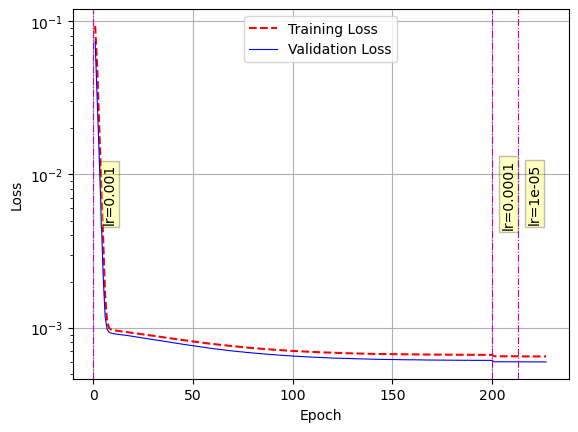

<Figure size 640x480 with 0 Axes>

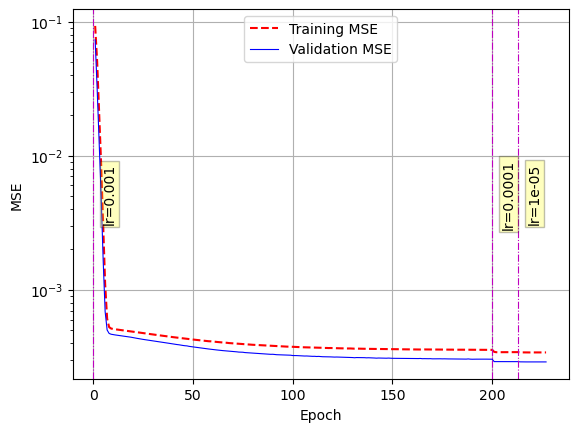

<Figure size 640x480 with 0 Axes>

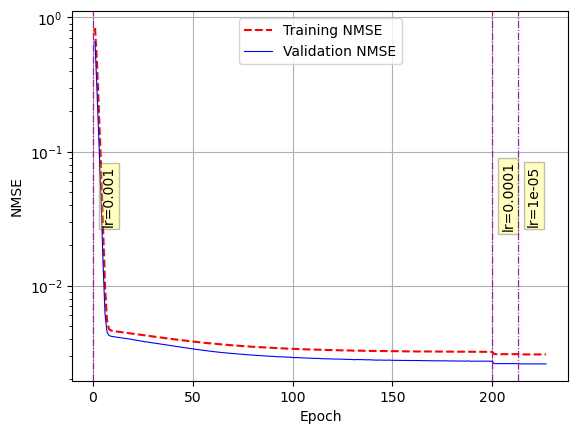

<Figure size 640x480 with 0 Axes>

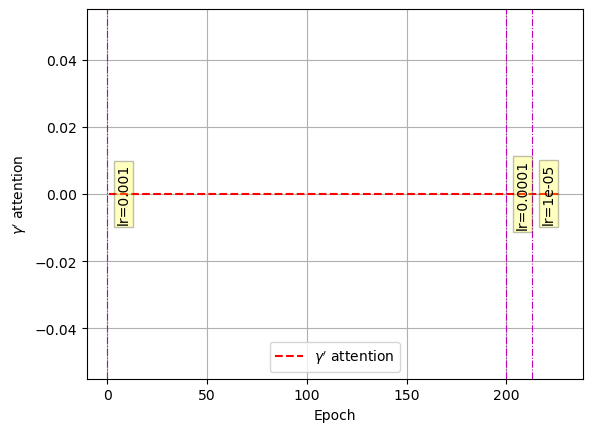

<Figure size 640x480 with 0 Axes>

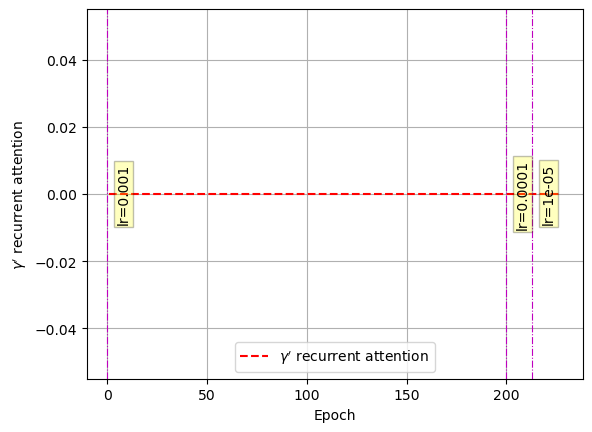

<Figure size 640x480 with 0 Axes>

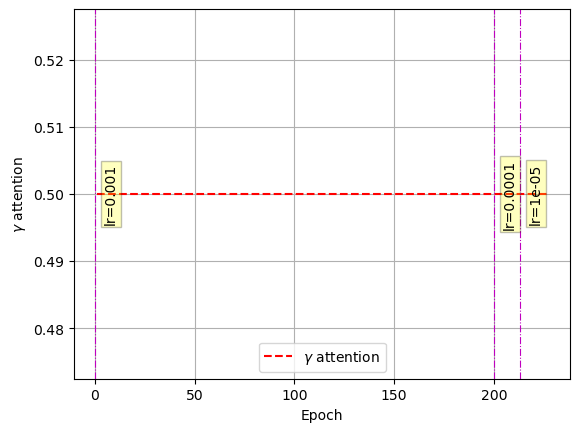

<Figure size 640x480 with 0 Axes>

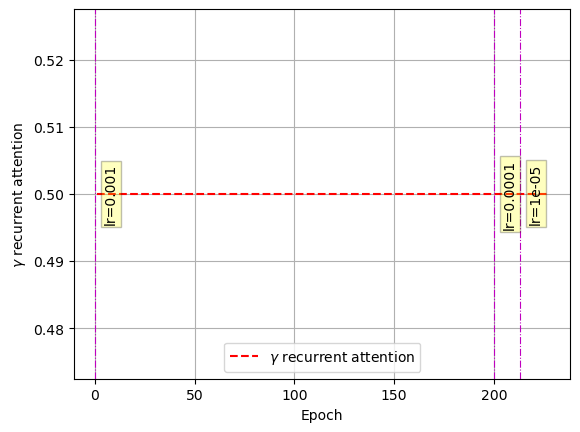

<Figure size 640x480 with 0 Axes>

In [53]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_gpa_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\gamma '$ attention"],
    xlabel='Epoch',
    ylabel=r"$\gamma '$ attention",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_GammaPrimeAttention.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_gpra_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\gamma '$ recurrent attention"],
    xlabel='Epoch',
    ylabel=r"$\gamma '$ recurrent attention",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_GammaPrimeRecurrentAttention.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


def sigmoid(x):
    return 0.5*np.tanh(x) + 0.5


fig, ax = plot_losses(
    training_loss=sigmoid(np.array(train_gpa_hist)),
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\gamma$ attention"],
    xlabel='Epoch',
    ylabel=r"$\gamma$ attention",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_GammaAttention.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=sigmoid(np.array(train_gpra_hist)),
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\gamma$ recurrent attention"],
    xlabel='Epoch',
    ylabel=r"$\gamma$ recurrent attention",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_GammaRecurrentAttention.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

data_idx : 55


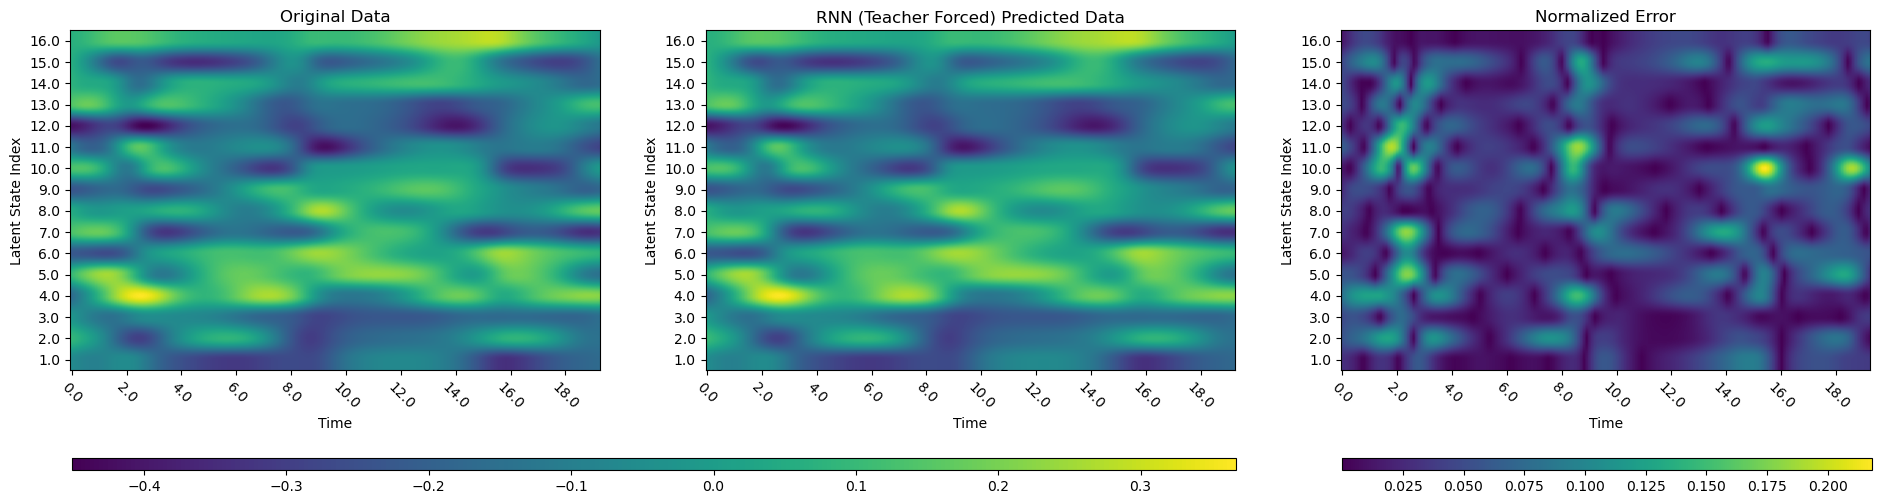

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((16, 193, 16), (193, 16), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 33


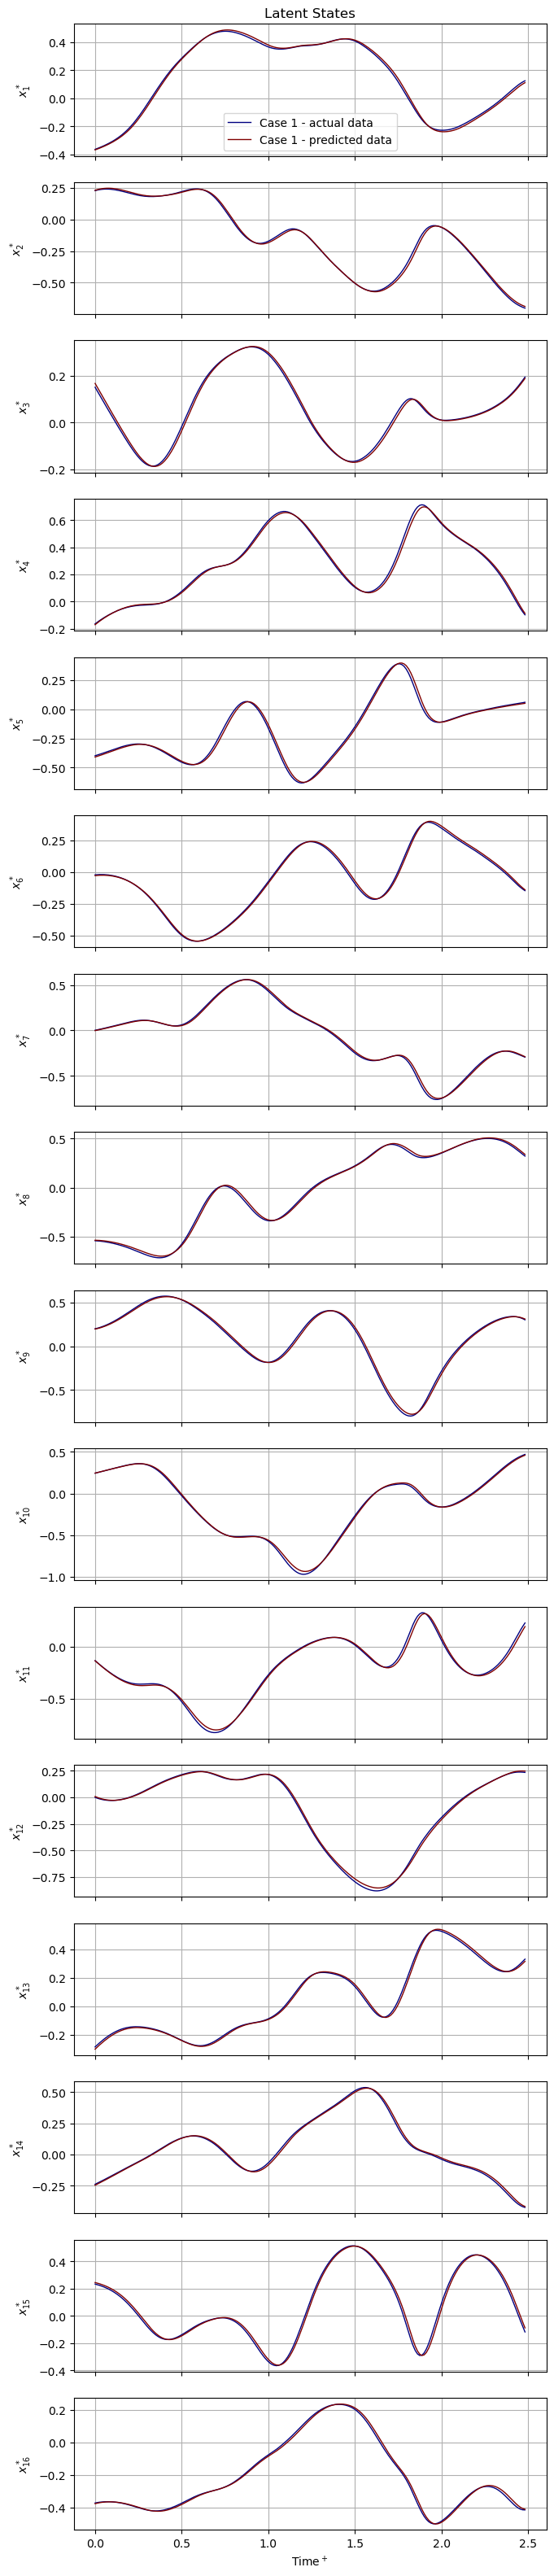


2.4828173257780812


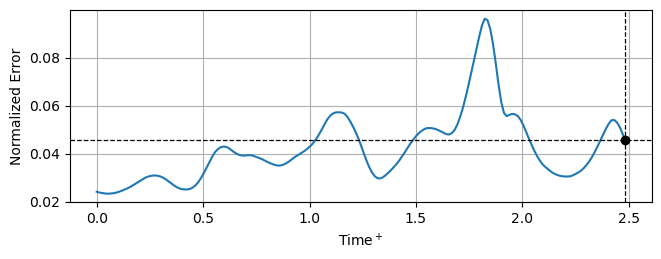

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[-0.01334152, -0.00261581,  0.02099581,  0.03006471,  0.0282602 ,
         0.0071317 ,  0.01005646,  0.07305361,  0.03375387,  0.02128131,
        -0.01137792, -0.0153523 ,  0.02832958,  0.00729525,  0.06112615,
         0.03638883],
       [ 0.57221735,  0.5165402 ,  0.56873006,  0.5798129 ,  0.5267395 ,
         0.5602617 ,  0.5400706 ,  0.5276647 ,  0.55953586,  0.4929259 ,
         0.45475405,  0.5388398 ,  0.49729973,  0.5216943 ,  0.44654998,
         0.49534416]], dtype=float32)

# Autoregressive Mode

In [54]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [55]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [56]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [57]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [58]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 18343
data_.shape : (1, 464, 16)


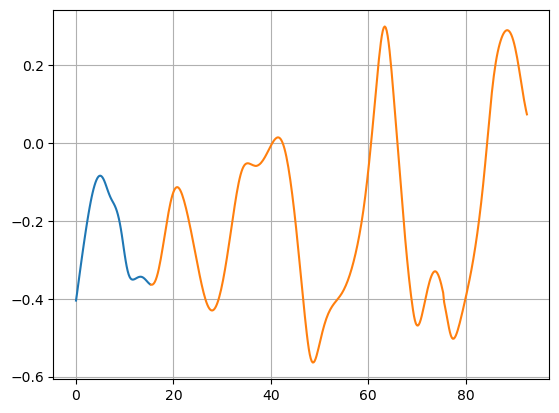

In [64]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [65]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [66]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (16, 77, 16)
prediction_lst.shape : (16, 387, 16)


In [67]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.2715581450069776


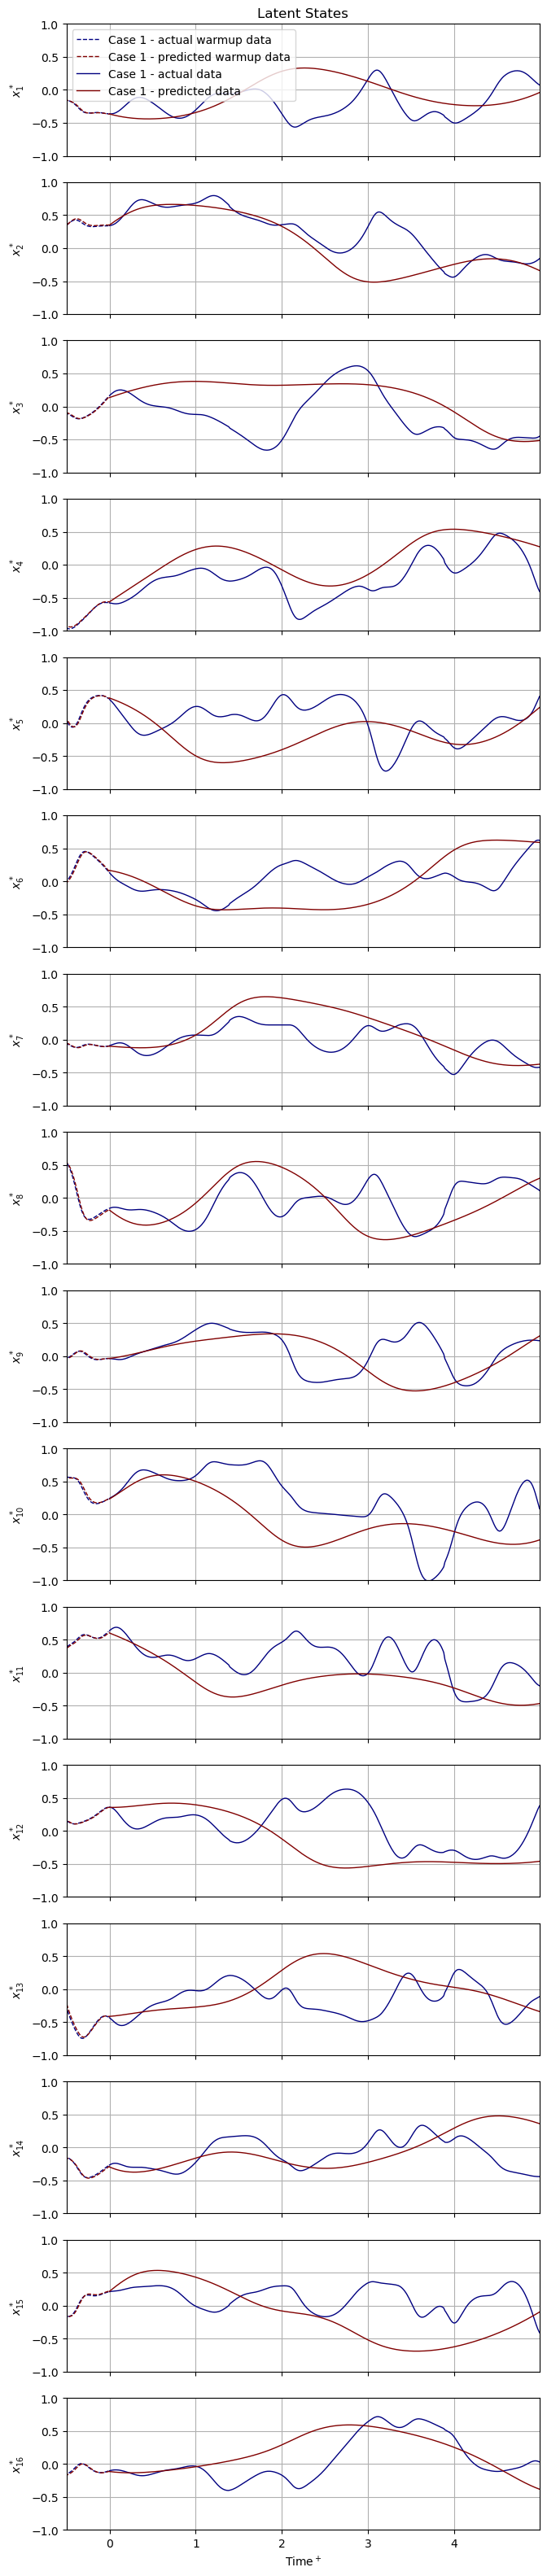

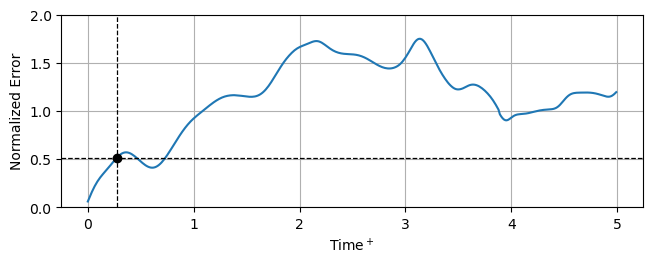

In [68]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [50]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [51]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn__cross_attention/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([2.5057607, 2.5214298, 2.5127852, 2.5360224, 2.583307 , 2.475952 ,
        2.4885352, 2.5505135, 2.5299883, 2.5453732, 2.5273876, 2.5176694,
        2.5389683, 2.5524273, 2.6041336, 2.4421077], dtype=float32)>]